<a href="https://colab.research.google.com/github/allen44/riiid-test-answer-prediction/blob/main/eda_train_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

%cd /content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/
%pwd

pwd = Path.cwd()


def ms_to_days(array_like):
  return np.divide(array_like, 86400000)

/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction


#Import the data

In [2]:
# #Alternatively, Load a DataFrame of train.csv from pikl for better performance on import than import from csv

# #Define data paths
# train_csv_path = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train.csv')
# train_pkl_path = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train.pkl.gzip')

# with open( train_pkl_path, 'rb') as f:
#   df = pickle.load(f)



In [3]:
#Make DataFrame from CSV
# train_csv_path = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train.csv')
# df = pd.read_csv(train_csv_path, index_col='row_id')

#After importing as a dataframe, save the dataframe as a binary file, in case the notebook instance crashes, so that we can quickly reload the dataframe and resume.
# %%time
# df.to_pickle(train_pkl_path)

In [4]:
# If loading the subsets from PKL after a runtime crash, use these:

#Define subset paths
train_pkl_path_1_1 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_1.pkl.gzip')
train_pkl_path_1_10 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_10.pkl.gzip')
train_pkl_path_1_100 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_100.pkl.gzip')
train_pkl_path_1_1000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_1000.pkl.gzip')
train_pkl_path_1_10000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_10000.pkl.gzip')
train_pkl_path_1_100000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_100000.pkl.gzip')
train_pkl_path_1_1000000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_1000000.pkl.gzip')
train_pkl_path_1_10000000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_10000000.pkl.gzip')

#Load the subsets
# with open( train_pkl_path_1_1, 'rb') as f:
#   df_1_1 = pickle.load(f)
# with open( train_pkl_path_1_10, 'rb') as f:
#   df_1_10 = pickle.load(f)
# with open( train_pkl_path_1_100, 'rb') as f:
#   df_1_100 = pickle.load(f)
with open( train_pkl_path_1_1000, 'rb') as f:
  df_1_1000 = pickle.load(f)
with open( train_pkl_path_1_10000, 'rb') as f:
  df_1_10000 = pickle.load(f)
with open( train_pkl_path_1_100000, 'rb') as f:
  df_1_100000 = pickle.load(f)
with open( train_pkl_path_1_1000000, 'rb') as f:
  df_1_1000000 = pickle.load(f)
with open( train_pkl_path_1_10000000, 'rb') as f:
  df_1_10000000 = pickle.load(f)

In [5]:
#Set the primary DataFrame for the EDA going forward

df = df_1_1000

#del unused large df
# if df_1_1:
#   del df_1_1

#EDA using a subsample
As the Google Colab runtime keeps crashing due to lack of memory (even with Colab Pro), we will switch to importing only about 1% or 10% of the data for this EDA. IF we see that this subset differs signifcant;y fullset's summary statistics, we can contiue to attempt using the full set.

###If subsetting from existing dataframe with all data

In [6]:
# #Define the skip logic

# #Skip rows from based on condition like skip every 10th line
# def skip_all_but_nth_rows(n, idx):
#   return (idx % n != 0)
  
# #Skip random lines  
# import random
# def rand_1_in_n(n, idx):
#   return True if random.randrange(1,n)==1 else False


# #Create the subsets 

# #Define a Dataframe with 1/1 of the data
# df_1_1 = df

# #Define a Dataframe with 1/10 of the data
# df_1_10 = df[df.index % 10 == 0]

# #Define a DataFrame with 1/100 of the data
# df_1_100 = df[df.index % 100 == 0]

# #Define a DataFrame with 1/1000 of the data
# df_1_1000 = df[df.index % 1000 == 0]

# #Define a Dataframe with 1/10000 of the data
# df_1_10000 = df[df.index % 10000 == 0]

# #Define a Dataframe with 1/100000 of the data
# df_1_100000 = df[df.index % 100000 == 0]

# #Define a Dataframe with 1/1000000 of the data
# df_1_1000000 = df[df.index % 1000000 == 0]

# #Define a Dataframe with 1/10000000 of the data
# df_1_10000000 = df[df.index % 10000000 == 0]


# #Define subset paths
# train_pkl_path_1_1 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_1.pkl.gzip')
# train_pkl_path_1_10 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_10.pkl.gzip')
# train_pkl_path_1_100 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_100.pkl.gzip')
# train_pkl_path_1_1000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_1000.pkl.gzip')
# train_pkl_path_1_10000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_10000.pkl.gzip')
# train_pkl_path_1_100000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_100000.pkl.gzip')
# train_pkl_path_1_1000000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_1000000.pkl.gzip')
# train_pkl_path_1_10000000 = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train_1_10000000.pkl.gzip')

# #Save subset dataframes to pkl
# df_1_1.to_pickle(train_pkl_path_1_1)
# df_1_10.to_pickle(train_pkl_path_1_10)
# df_1_100.to_pickle(train_pkl_path_1_100)
# df_1_1000.to_pickle(train_pkl_path_1_1000)
# df_1_10000.to_pickle(train_pkl_path_1_10000)
# df_1_100000.to_pickle(train_pkl_path_1_100000)
# df_1_1000000.to_pickle(train_pkl_path_1_1000000)
# df_1_10000000.to_pickle(train_pkl_path_1_10000000)

In [7]:
# df_1_1.head() 

In [8]:
# df_1_100.head()

In [9]:
# df_1_100000.head()

For the remainder of this eda, let's use the 1/1000 dataframe.

In [10]:
# df_1 = df
# df = df_1_1000
# df.head()

In [11]:
# df.shape

#Pandas Profiling Report

In [12]:
# # Install updated pandas profiling

#  %load_ext autoreload
# %autoreload 2

# import sys
# !{sys.executable} -m pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# !jupyter nbextension enable --py widgetsnbextension

# %autoreload 0

In [13]:
# #Set the primary DataFrame for the EDA going forward

df = df_1_1000

In [14]:
#Generate Pandas Profiling Report - may be slow running if using the largest subsets of the data
import pandas_profiling

#Define Pandas Profile Report save path
pandas_profiling_report_path = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/viz/pandas_profiling_report.html')

report = df.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)
report

In [15]:
#Save report to file
# version_suffix = ' df_1_1000'
# pandas_profiling_report_path = f'/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/viz/pandas_profiling_report{version_suffix}.html'


# report.to_file(pandas_profiling_report_path)

In [16]:

# !touch '/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/viz/pandas_profiling_report df_1_1000.html'

#Examine the shape of the dataframe, summary statistics, and missing values

In [17]:
df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,NaN
1000,15092942969,13134,9155,0,299,3,1,27666.0,True
2000,1623047964,24418,476,0,112,0,1,15000.0,True
3000,4746311751,24418,5168,0,1000,1,1,6000.0,True
4000,5617496174,24418,3746,0,1747,3,0,27000.0,True


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101231 entries, 0 to 101230000
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   timestamp                       101231 non-null  int64  
 1   user_id                         101231 non-null  int64  
 2   content_id                      101231 non-null  int64  
 3   content_type_id                 101231 non-null  int64  
 4   task_container_id               101231 non-null  int64  
 5   user_answer                     101231 non-null  int64  
 6   answered_correctly              101231 non-null  int64  
 7   prior_question_elapsed_time     98814 non-null   float64
 8   prior_question_had_explanation  100827 non-null  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 7.7+ MB


In [19]:
print(f"The shape of this dataframe is {df.shape}.")

The shape of this dataframe is (101231, 9).


##Check for missing data

In [20]:
# Count missing values
df.isna().sum()

timestamp                            0
user_id                              0
content_id                           0
content_type_id                      0
task_container_id                    0
user_answer                          0
answered_correctly                   0
prior_question_elapsed_time       2417
prior_question_had_explanation     404
dtype: int64

The data is mostly clean, and only two columns have missing data. Based on the discriptions of the data, these columns missing data is intentional.


##Check unique entries and dtypes

In [21]:
#Check the relative frequency of unique values in each column
# Save the values here, to avoid re-computation later
%time
df_nunique = df.nunique()
df_nunique

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


timestamp                         100802
user_id                            67050
content_id                         11713
content_type_id                        2
task_container_id                   6701
user_answer                            5
answered_correctly                     3
prior_question_elapsed_time         1305
prior_question_had_explanation         2
dtype: int64

In [22]:
nunique_answered_correctly = df_nunique['answered_correctly']
nunique_prior_question_had_explanation = df_nunique['prior_question_had_explanation']

nunique_answered_correctly, nunique_prior_question_had_explanation

(3, 2)

Noteably, the number of unique task_container_id is exactly 10000. 

'answered_correctly' is a boolean except for the NaN entries.



##Set the index

In [23]:
%time
if 'row_id' in df.columns:
  df.set_index('row_id', inplace=True)
df.head()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs


,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,NaN
1000,15092942969,13134,9155,0,299,3,1,27666.0,True
2000,1623047964,24418,476,0,112,0,1,15000.0,True
3000,4746311751,24418,5168,0,1000,1,1,6000.0,True
4000,5617496174,24418,3746,0,1747,3,0,27000.0,True


## Changing dtypes
As the number of unique entries in each column is comparatively low, relative to the size of the data set, there will be perfomance gains by recaasting most of these colums as categorical variables.

timestamp and prior_question_elapsed_time            is an exception and should be treated differently.

prior_question_elapsed_time is a float and probably should not be categorical.

prior_question_had_explanation should be change to dtype:bool


In [24]:
#Check dtypes before
%time
df.dtypes

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


timestamp                           int64
user_id                             int64
content_id                          int64
content_type_id                     int64
task_container_id                   int64
user_answer                         int64
answered_correctly                  int64
prior_question_elapsed_time       float64
prior_question_had_explanation     object
dtype: object

In [25]:
%time
categorical_columns = ['user_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer', 'answered_correctly']
for column_id in categorical_columns:
  df[column_id] = pd.Categorical(df[column_id])

boolean_columns = ['prior_question_had_explanation']
for column_id in boolean_columns:
  df[column_id] = df[column_id].astype(bool)

df.dtypes

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


timestamp                            int64
user_id                           category
content_id                        category
content_type_id                   category
task_container_id                 category
user_answer                       category
answered_correctly                category
prior_question_elapsed_time        float64
prior_question_had_explanation        bool
dtype: object

Check to make sure the missing data is retained.

# Exploring the data in each column, individually

Descriptions of each column (from the Kaggle website):


row_id: (int64) ID code for the row.

  timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.

user_id: (int32) ID code for the user.

content_id: (int16) ID code for the user interaction

content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.

prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.

prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.





##timestamp

>timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.

In [26]:
df['timestamp'].describe(include='all')

count    1.012310e+05
mean     7.691479e+09
std      1.156822e+10
min      0.000000e+00
25%      5.282159e+08
50%      2.661673e+09
75%      9.936980e+09
max      8.458382e+10
Name: timestamp, dtype: float64

Converting this from ms to years may be useful.

In [27]:
timestamp_in_days = ms_to_days(df['timestamp'])
timestamp_in_days.describe(include='all')

count    101231.000000
mean         89.021751
std         133.891492
min           0.000000
25%           6.113609
50%          30.806404
75%         115.011346
max         978.979438
Name: timestamp, dtype: float64

n_bins = 318


Text(0.5, 1.0, '')

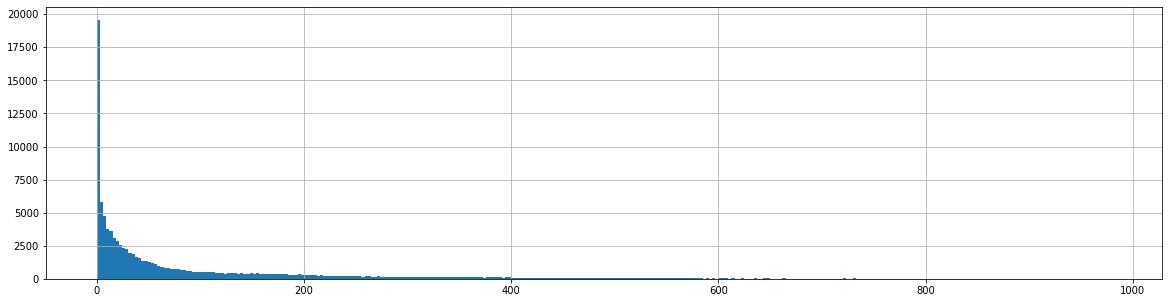

In [28]:
# %time
n_bins = int(np.sqrt(len(df)))
print(f'n_bins = {n_bins}')
timestamp_in_days.hist(bins=n_bins, figsize=(20, 5))
plt.title('')

Let plot to see the distribution of the data, along with summary statistics. The majority of the events are from users accounts that are less than 200 days old.

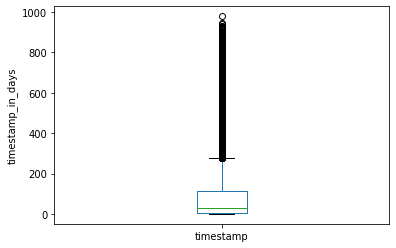

In [29]:
timestamp_in_days.plot(kind='box')
plt.ylabel('timestamp_in_days')
plt.show()

A boxplot would be more informative with a log y-scale

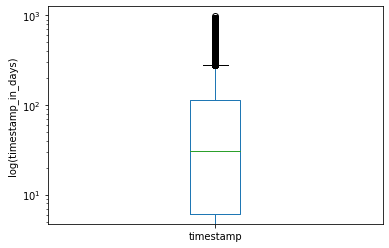

In [30]:
timestamp_in_days.plot(kind='box', logy=True)
plt.ylabel('log(timestamp_in_days)')
plt.show()

A box plot shows that that the timestamps generally have values 6 days and 105 days. 

It would be useful to check later if some users use the platform much more than others.

There is a right-skewness but no reason yet to consider these as outliers to drop or correct.

Most of the data entries were from relatively "young" user accounts, while a minority of data are from older user accounts. The units here are milliseconds since account creations, so the average action took place about 0.23 years after account creation.

In [31]:
#Add this to the df as a column
df['timestamp_in_days'] = timestamp_in_days
df.shape

(101231, 10)

##user_id

This is presumed to a unique user id that is randomly distributed to each user, with one per user.

This data can be used to relate data etries from the same users through out the data set.


In [32]:
#Count the unique users in this data set
unique_users = df['user_id'].unique()
unique_users

[115, 13134, 24418, 53842, 91216, ..., 2147375580, 2147413636, 2147419988, 2147470770, 2147481750]
Length: 67050
Categories (67050, int64): [115, 13134, 24418, 53842, ..., 2147413636, 2147419988, 2147470770,
                            2147481750]

In [33]:
user_id_value_counts = df['user_id'].value_counts()
user_id_value_counts

801103753     18
1743444187    17
1615528747    17
1478712595    17
1047202059    17
              ..
1340984341     1
1340900830     1
1340881119     1
1340812249     1
115            1
Name: user_id, Length: 67050, dtype: int64

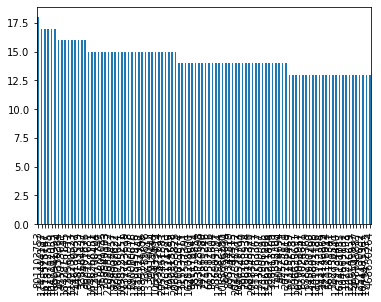

In [34]:
user_id_value_counts[:100].plot(kind='bar')

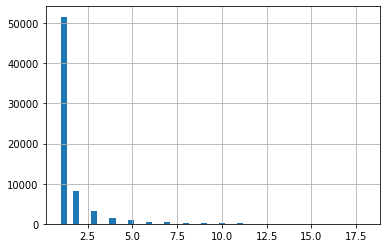

In [35]:
user_id_value_counts.hist(bins=50)

We can see that a small minority of users generate most of the 

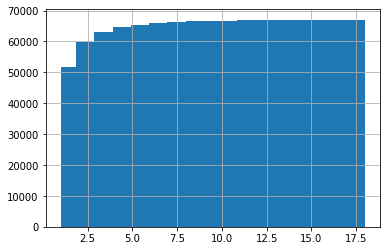

In [36]:
user_id_value_counts.hist(cumulative=True, bins=100)

##content_id

How many different content_id are there? How often does the most common content_ID occur? Does any small group of content_ids form a disproportionate amount of the events?

In [37]:
df_content_id_value_counts = df['content_id'].value_counts()
df_content_id_value_counts.describe()

count    11713.000000
mean         8.642619
std         12.286927
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max        230.000000
Name: content_id, dtype: float64

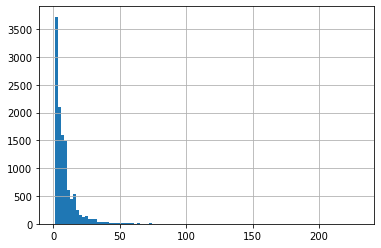

In [38]:
#Count the unique content_ids and describe the distribution of the counts

df_content_id_value_counts.hist(bins=100);

We  13320 unique content ids.

The most common content_id occured only {{{df_content_id_value_counts.max()}}} of the time. The average content_id occurs about 0.007% of the time.

It may be useful to consider these in groups, because any single content_id is such a small part of the whole set.


##content_type_id

>content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.



In [39]:
#Count the unique content_type_ids and describe the distribution of the counts
content_type_id_value_counts = df['content_type_id'].value_counts()
content_type_id_value_counts

0    99218
1     2013
Name: content_type_id, dtype: int64

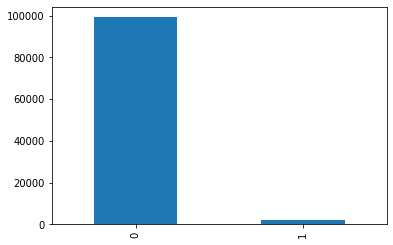

In [40]:
content_type_id_value_counts.plot(kind='bar')

We note that ther are only two content_id_types.


 Most of the data are questions posed to the user.

In [41]:
print(f"{100*content_type_id_value_counts[1]/len(df)}% of the data is the user watching a lecture.")

1.9885213027629876% of the data is the user watching a lecture.


##task_container_id

>task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

In [42]:
#Count the unique task_container_id and describe the distribution of the counts
task_container_id = df['task_container_id']
task_container_id.value_counts()

14      834
15      769
4       693
5       690
7       685
       ... 
3821      1
5818      1
5817      1
3126      1
9994      1
Name: task_container_id, Length: 6701, dtype: int64

In [43]:
task_container_id.value_counts(normalize=True)

14      0.008239
15      0.007596
4       0.006846
5       0.006816
7       0.006767
          ...   
3821    0.000010
5818    0.000010
5817    0.000010
3126    0.000010
9994    0.000010
Name: task_container_id, Length: 6701, dtype: float64

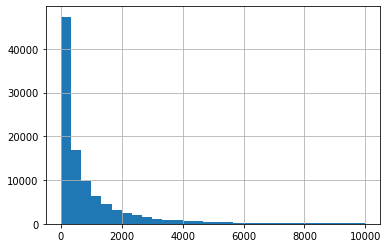

In [44]:
#Count the unique task_container_id and describe the distribution of the counts

task_container_id.hist(bins=30)

Of the 10000 task_container_ids, over 85% have a the data use the task_container_id with id less than 2000.

It's notable that the task_container_ids with the lowest numbers tend to occur most frequently. Perhaps these id were not randomly assigned from a hash but were assigned sequentially.

It could be useful to dig in to the docs and find if certain task_container_ids have further meaning which could be useful in feature engineering.

Many of the highest numbered task_container_id only occur once. It''s possble that these task_container_id are unique to a user.

##user_answer

>user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

In [45]:
#Count the unique task_container_id and describe the distribution of the counts
user_answer_value_counts = df['user_answer'].value_counts()
user_answer_value_counts

0     28189
1     27104
3     26069
2     17856
-1     2013
Name: user_answer, dtype: int64

In [46]:
user_answer_value_counts_normalized = df['user_answer'].value_counts(normalize=True)
user_answer_value_counts_normalized

0     0.278462
1     0.267744
3     0.257520
2     0.176389
-1    0.019885
Name: user_answer, dtype: float64

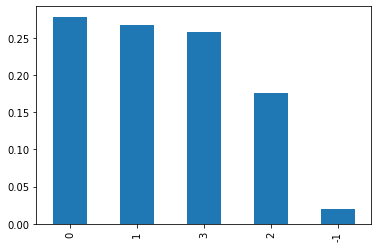

In [47]:
user_answer_value_counts_normalized.plot(kind='bar')

W can see here that about 2% of the events ((encoded as '-1') were lectures --not questions--so no answer was asked from the student.

Let's split the Dataframe so that we continue to examine only the questions, not the lectures.

###Splitting the data into lectures and questions dataframes

In [48]:
is_lecture= df['user_answer'] == -1
is_question = df['user_answer'] != -1

df_l = df[is_lecture]
df_q = df[is_question]

df_q.shape, df_l.shape

((99218, 10), (2013, 10))

From here, let's consider only the questions data.

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,answered_correctly
user_answer,
-1,NaN
0,0.661535
1,0.647653
2,0.666891
3,0.661437


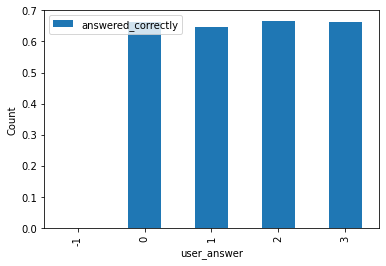

In [49]:
df_q.answered_correctly = df.answered_correctly.astype(int)
df_q.groupby(['user_answer'])[['answered_correctly']].mean().plot(kind='bar').set_ylabel('Count')
df_q.groupby(['user_answer'])[['answered_correctly']].mean()

In [50]:
#Chi-Square https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

# Plot univar and bi-variate charts next to eachother

It looks like the these are multiple choice answers. Of the 4 nonlecture types, it looks like there is a negative bias on category 2. That is, users answer '2' less often then expected from chance alone. It could be that the users are inherently biased aginast answering with  '2', or possibly, the questions creators are have biased questions so that users are less likely to select '2', or it could be something else. 

We may have to transform this column later so that the '-1' values are not in this coloumn, depending on the requirements of the pipelines we use later. An easy transform might be to asssign NaN to these '-1' values.

##answered_correctly (Target variable)

`answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.`

In [51]:
#Count the unique task_container_id and describe the distribution of the counts
df_q['answered_correctly'].value_counts()

1    65353
0    33865
Name: answered_correctly, dtype: int64

In [52]:
#Check the frequency of each count
df_q['answered_correctly'].value_counts(normalize=True)

1    0.658681
0    0.341319
Name: answered_correctly, dtype: float64

The '-1' occurs here exactly as frequent as in user_answer. It might be best to seperate the lecture rows entirtely from the rest of the dataframe, rather than transform it.

##prior_question_elapsed_time

`prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.`

It might be possible to determine each user's first lecture from this point alone.
 

In [53]:
#Count the unique prior_question_elapsed_time and describe the distribution of the counts
prior_question_elapsed_time = df_q['prior_question_elapsed_time']
prior_question_elapsed_time.value_counts()

17000.0     5291
16000.0     4737
18000.0     4606
19000.0     4094
15000.0     3756
            ... 
74333.0        1
16400.0        1
159250.0       1
90666.0        1
111250.0       1
Name: prior_question_elapsed_time, Length: 1305, dtype: int64

In [54]:
#Check the frequency of each count
prior_question_elapsed_time.value_counts(normalize=True)


17000.0     0.053545
16000.0     0.047939
18000.0     0.046613
19000.0     0.041431
15000.0     0.038011
              ...   
74333.0     0.000010
16400.0     0.000010
159250.0    0.000010
90666.0     0.000010
111250.0    0.000010
Name: prior_question_elapsed_time, Length: 1305, dtype: float64

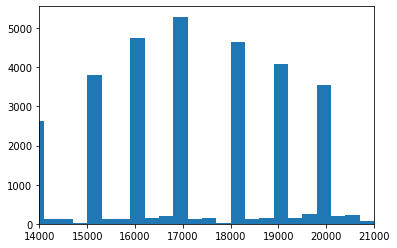

In [55]:

plt.hist(prior_question_elapsed_time, bins=1000)
plt.xlim((14000, 21000))
plt.show()


Well, this looks peculiar. The top 5 value counts are 17.000 seconds, 16.000 seconds, 18.000 seconds, 19.000 seconds, and 15.000. The units is milliseconds, but these top five values appear to either have been rounded to the nearest second, or the students are machinely-like in their precision of submitting the answer on the exact milliseconds so that the delay is multiple of 1000 millisenconds. 

Alternatively, an automated tool, like a test-taking bot--designed to harvest test questions by guessing any answer while scraping the question content to store in a database for use later--has been answering questions with a simulated delay that can be modeled by a discrete normal distribution with mean 17000. The magnitude of this hypoithesized automnation is such that around 20% of all answers submitted could fit this model.

Cross-referencing user_ids connected to these anomolus prior_question_elapsed_time values could lend support to the hypothesis if there are a small number of user ids who make a disprotionate amount of all answers.

If the hypothesis is true,
It may be useful later to feature-engineer these automated users (bots) into their own column or dataframe, as their behavior could be quite different from the human users. It may be easier to model the responses of the bots seperately from the humans.

An alternative explanation could be that, assuming this educational platform is accessed via a web browser, some web browsers may round times  to whole-number of seconds. It unlikely though. Also, this fails to address the simulated discrete normal distribution about 17.000 seconds.

Let's continue without seperating the two populations for now...

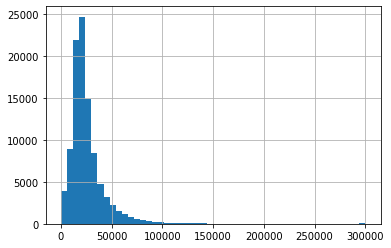

In [56]:
prior_question_elapsed_time.hist(bins=50)

In [57]:
prior_question_elapsed_time.describe()

count     98814.000000
mean      25413.342704
std       19982.012162
min           0.000000
25%       16000.000000
50%       21000.000000
75%       29666.000000
max      300000.000000
Name: prior_question_elapsed_time, dtype: float64

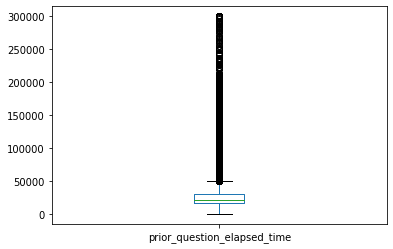

In [58]:
prior_question_elapsed_time.plot(kind='box')

Using a log scale on the y-axis for clarity:

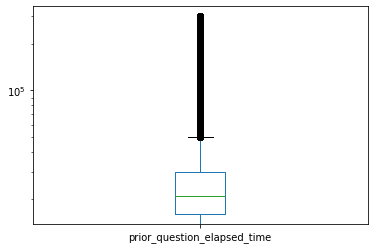

In [59]:
prior_question_elapsed_time.plot(kind='box', logy=True)

Mean time to answer the last question is about 25 seconds; the median is 21.000 seconds.

The effect of the hypothesized bot subpopulation is large enough that it is convolutes our summary statistics on the whole population. We see that the 25th-percentile and median are 16.000 seconds and 21.000 seconds. 

It looks like there a hard cutoff on answer times at 5 minutes (300000 milliseconds).

We might have to discard answers given with delay 0, as I don't know what they mean yet.


##prior_question_had_explanation

`prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.`





In [60]:
prior_question_had_explanation = df['prior_question_had_explanation']

In [61]:
prior_question_had_explanation.value_counts()

True     90068
False    11163
Name: prior_question_had_explanation, dtype: int64

I'm not quite sure what this means here. I might have to read the documentation more to learn about what the nearly 90% fraction of prioor questions that had an explanation after.

#Exploring the data in each column vs the target variable.

In [62]:
#Create a list of features
target_var_str = 'answered_correctly'
features = [feature for feature in df.columns if feature not in [target_var_str]]
features

['timestamp',
 'user_id',
 'content_id',
 'content_type_id',
 'task_container_id',
 'user_answer',
 'prior_question_elapsed_time',
 'prior_question_had_explanation',
 'timestamp_in_days']

##Numerical Variables vs the target variable (Box plots)

###prior_question_elapsed_time

In [63]:
df_q.groupby('answered_correctly')['prior_question_elapsed_time'].describe()

,count,mean,std,min,25%,50%,75%,max
answered_correctly,,,,,,,,
0,33742.0,25644.347431,20551.178768,0.0,15333.0,21000.0,30000.0,300000.0
1,65072.0,25293.559058,19679.493436,0.0,16000.0,21000.0,29000.0,300000.0


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Prior Question Elapsed Time (ms)')

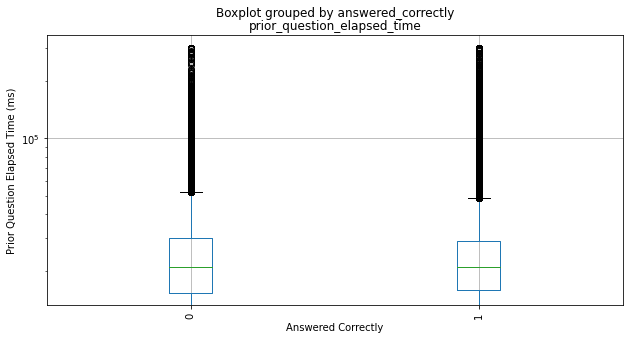

In [64]:
# df.plot(kind='box', x='answered_correctly', y='prior_question_elapsed_time', logy=True)

df_q.boxplot(column=['prior_question_elapsed_time'],by = ['answered_correctly'], rot=90, figsize=(10,5)).set_yscale('log')
plt.xlabel('Answered Correctly')
plt.ylabel('Prior Question Elapsed Time (ms)')

In [65]:
df_q.isna().count()

timestamp                         99218
user_id                           99218
content_id                        99218
content_type_id                   99218
task_container_id                 99218
user_answer                       99218
answered_correctly                99218
prior_question_elapsed_time       99218
prior_question_had_explanation    99218
timestamp_in_days                 99218
dtype: int64

In [66]:
from scipy import stats
rvs1 = df_q[df_q['answered_correctly'] == 0]['prior_question_elapsed_time'].dropna()
rvs2 = df_q[df_q['answered_correctly'] == 1]['prior_question_elapsed_time'].dropna()
stats.ttest_ind(rvs1,rvs2)

Ttest_indResult(statistic=2.616929787853998, pvalue=0.00887380964374365)

In [67]:
rvs1.mean(), rvs2.mean()

(25644.347430502046, 25293.559057659208)

The average prior_question_elapsed_time that is smaller correlates with the correct answer on the current question. 

###content_id

In [68]:
df_1 = df_q.groupby(['content_id'])[['answered_correctly']].mean()
# ax = df_1['content_id'].hist()
df_1

,answered_correctly
content_id,
0,1.000000
1,1.000000
2,0.605263
3,0.857143
4,0.655172
...,...
32491,NaN
32535,NaN
32570,NaN


We note that there are 13 thousand unique content_ids and the first 2 were correctly answered by everyone.

Text(0, 0.5, 'Frequency of content_ids')

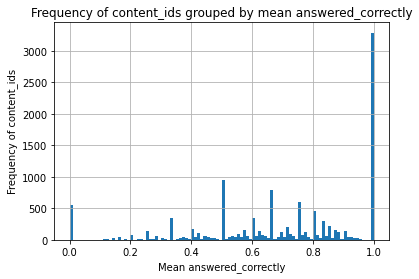

In [69]:
df_1.hist(bins=100)
plt.title('Frequency of content_ids grouped by mean answered_correctly');
plt.xlabel('Mean answered_correctly')
plt.ylabel('Frequency of content_ids')

There are lots of content_ids where every question was answered correctly.

###user_id grouped by account age

Do older user accounts have a higher rate of answering correctly?

In [70]:
# We can group the users by account age by finding the answer for each user with the largest stamp. 
user_id_timestamp_max = df.groupby('user_id')['timestamp'].max()

In [71]:
user_id_timestamp_max.sort_values(ascending=False).map(ms_to_days)

user_id
153187243     978.979438
550249756     943.922619
937249824     940.061026
311071830     931.350724
697068556     929.149646
                 ...    
154128958       0.000000
154801048       0.000000
648354221       0.000000
1946966069      0.000000
115             0.000000
Name: timestamp, Length: 67050, dtype: float64

The oldest accounts are over 900 days old.

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,user_id,timestamp_x,timestamp_y,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,timestamp_in_days
0,115,0,0,5692,0,1,3,1,NaN,True,0.000000
1,13134,15092942969,15092942969,9155,0,299,3,1,27666.0,True,174.686840
2,24418,13210395375,1623047964,476,0,112,0,1,15000.0,True,18.785277
3,24418,13210395375,4746311751,5168,0,1000,1,1,6000.0,True,54.934164
4,24418,13210395375,5617496174,3746,0,1747,3,0,27000.0,True,65.017317


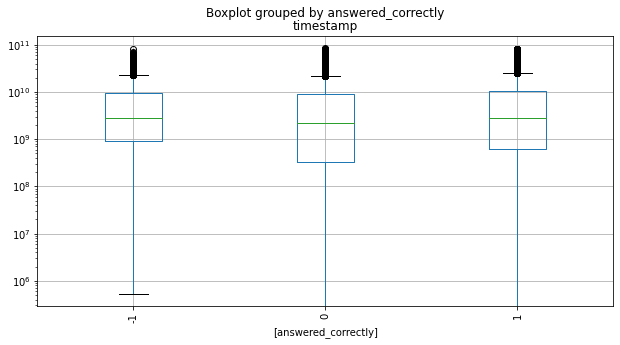

In [72]:
df_temp = pd.DataFrame(user_id_timestamp_max)
df_temp = pd.merge(df_temp, df, on='user_id')
df.boxplot(column=['timestamp'],by = ['answered_correctly'], rot=90, figsize=(10,5)).set_yscale('log')
df_temp.head()

In [73]:
df.shape

(101231, 10)

###timestamp

Is there a relationship between timestamp and answered_correctly?

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


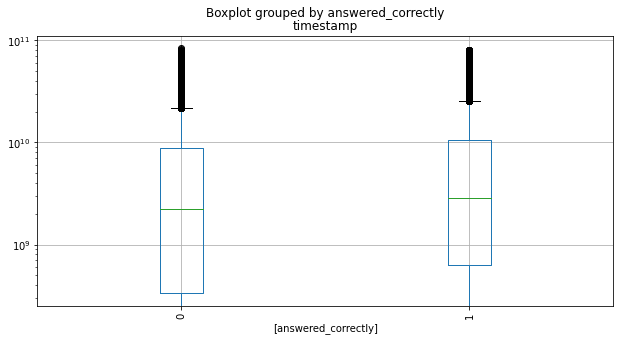

In [74]:
df_q.boxplot(column=['timestamp'],by = ['answered_correctly'], rot=90, figsize=(10,5)).set_yscale('log')

That's hard to visualize, becasue the values are so large. Let's try using the timestamp_in_days

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


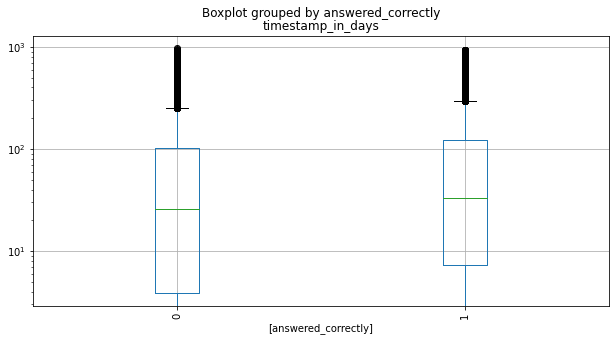

In [75]:
df_q.boxplot(column=['timestamp_in_days'],by = ['answered_correctly'], rot=90, figsize=(10,5)).set_yscale('log')

That's a bit easier to read. We see that correctly answered questions had larger timestamps and smaller variation in the timestamps.

In [76]:
rvs1 = df_q[df_q['answered_correctly'] == 0]['timestamp_in_days'].dropna()
rvs2 = df_q[df_q['answered_correctly'] == 1]['timestamp_in_days'].dropna()
stats.ttest_ind(rvs1,rvs2)

Ttest_indResult(statistic=-10.473320183622857, pvalue=1.181417462038879e-25)

In [77]:
rvs1.mean(), rvs2.mean()

(82.8308571851491, 92.21969502615643)

We see that a correctly answered question correlates with an older account. Given a correctly answered question, the associated timestamp is about 10 days larger.

###user_id grouped by number of entries

Are frequent users more likely to answer correctly than infrequent users?

In [78]:
#Count entries by each user, each event has a unique timestamp
user_id_event_count= df.groupby('user_id')['timestamp'].count()
user_id_event_count.sort_values(ascending=False)

user_id
801103753     18
1743444187    17
1615528747    17
1478712595    17
1047202059    17
              ..
1340984341     1
1340900830     1
1340881119     1
1340812249     1
115            1
Name: timestamp, Length: 67050, dtype: int64

Let's add this to the DataFrame

In [79]:
df = df.merge(user_id_event_count, how='left', on='user_id', suffixes=('','_y'))
df['user_id_event_count'] = df['timestamp_y']
df.drop(columns=['timestamp_y'], inplace=True)
df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,timestamp_in_days,user_id_event_count
0,0,115,5692,0,1,3,1,NaN,True,0.000000,1
1,15092942969,13134,9155,0,299,3,1,27666.0,True,174.686840,1
2,1623047964,24418,476,0,112,0,1,15000.0,True,18.785277,7
3,4746311751,24418,5168,0,1000,1,1,6000.0,True,54.934164,7
4,5617496174,24418,3746,0,1747,3,0,27000.0,True,65.017317,7


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


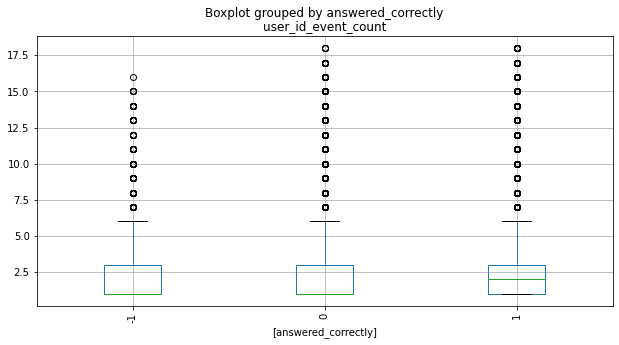

In [80]:
df.boxplot(column=['user_id_event_count'],by = ['answered_correctly'], rot=90, figsize=(10,5))

For incorrectly answered questions, the minimum and the median number of events are 1.

For correctly answered questions, the median is 2.

In [81]:
rvs1 = df[df['answered_correctly'] == 0]['user_id_event_count'].dropna()
rvs2 = df[df['answered_correctly'] == 1]['user_id_event_count'].dropna()
stats.ttest_ind(rvs1,rvs2)

Ttest_indResult(statistic=-16.877529587810212, pvalue=8.086389406300338e-64)

In [82]:
rvs1.mean(), rvs2.mean()

(2.525143953934741, 2.843633804109987)

Inline with the timestamp column (timestamp is unique to each answer), the older user accounts have a higher accuracy on answering questions.

In [83]:
df.user_id.describe()

count        101231
unique        67050
top       801103753
freq             18
Name: user_id, dtype: int64

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101231 entries, 0 to 101230
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   timestamp                       101231 non-null  int64   
 1   user_id                         101231 non-null  category
 2   content_id                      101231 non-null  category
 3   content_type_id                 101231 non-null  category
 4   task_container_id               101231 non-null  category
 5   user_answer                     101231 non-null  category
 6   answered_correctly              101231 non-null  category
 7   prior_question_elapsed_time     98814 non-null   float64 
 8   prior_question_had_explanation  101231 non-null  bool    
 9   timestamp_in_days               101231 non-null  float64 
 10  user_id_event_count             101231 non-null  int64   
dtypes: bool(1), category(6), float64(2), int64(2)
memory usage: 8.8 M

In [85]:
df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,timestamp_in_days,user_id_event_count
0,0,115,5692,0,1,3,1,NaN,True,0.000000,1
1,15092942969,13134,9155,0,299,3,1,27666.0,True,174.686840,1
2,1623047964,24418,476,0,112,0,1,15000.0,True,18.785277,7
3,4746311751,24418,5168,0,1000,1,1,6000.0,True,54.934164,7
4,5617496174,24418,3746,0,1747,3,0,27000.0,True,65.017317,7


##Categorical Variables vs Target variable (Chi-Square)

Let's list the categorical variables, and define some useful functions for this section.

In [86]:
#Categorical variables
cat_vars_list = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
cat_vars_list

['user_id',
 'content_id',
 'content_type_id',
 'task_container_id',
 'user_answer',
 'answered_correctly',
 'prior_question_had_explanation']

###user_id
Recall that there are lots and lots of unique user ids--too many to do a chi square on each. Instead let's do a chi-squar on the top 50 most frequent users.

In [87]:
user_id_contigency_table = pd.crosstab(index=df_q['answered_correctly'], 
                                       columns=df_q['user_id'], 
                                       margins=True)
user_id_contigency_table

user_id,115,13134,24418,53842,91216,107002,128919,138650,141455,166728,220268,275762,359283,384745,408119,459017,475020,478631,496840,613296,650467,686708,713424,807172,859071,975595,1024273,1067196,1084314,1095916,1108148,1186307,1222551,1255931,1272775,1282581,1283277,1283420,1359985,1409904,...,2146130037,2146179582,2146244941,2146293168,2146339228,2146358657,2146407811,2146456517,2146475932,2146490254,2146516200,2146573313,2146605427,2146621766,2146672872,2146672950,2146686585,2146701821,2146720038,2146722955,2146786289,2146823424,2146903512,2146925942,2146986426,2146998173,2147012157,2147070951,2147143229,2147170757,2147192385,2147192453,2147262405,2147301437,2147375580,2147413636,2147419988,2147470770,2147481750,All
answered_correctly,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,3,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,1,0,0,0,1,1,0,1,0,0,0,0,0,0,...,4,1,0,0,0,1,0,1,0,1,1,1,2,0,1,1,1,0,1,0,1,1,1,0,0,0,0,1,1,0,1,1,0,0,0,2,0,1,1,33865
1,1,1,4,0,1,2,1,0,2,0,2,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,1,2,1,1,0,1,0,1,5,1,7,1,1,...,12,0,1,1,1,1,1,0,1,0,3,1,0,1,0,2,0,2,0,2,0,0,1,1,6,1,8,0,1,1,0,0,1,1,1,1,1,0,0,65353
All,1,1,7,1,1,2,1,1,2,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,2,1,2,1,1,1,1,5,1,7,1,1,...,16,1,1,1,1,2,1,1,1,1,4,2,2,1,1,3,1,2,1,2,1,1,2,1,6,1,8,1,2,1,1,1,1,1,1,3,1,1,1,99218


In [88]:
user_id_contigency_table_with_margins = pd.crosstab(index=df_q['answered_correctly'], 
                                                    columns=df_q['user_id'], 
                                                    margins=True)
user_id_contigency_table_with_margins

user_id,115,13134,24418,53842,91216,107002,128919,138650,141455,166728,220268,275762,359283,384745,408119,459017,475020,478631,496840,613296,650467,686708,713424,807172,859071,975595,1024273,1067196,1084314,1095916,1108148,1186307,1222551,1255931,1272775,1282581,1283277,1283420,1359985,1409904,...,2146130037,2146179582,2146244941,2146293168,2146339228,2146358657,2146407811,2146456517,2146475932,2146490254,2146516200,2146573313,2146605427,2146621766,2146672872,2146672950,2146686585,2146701821,2146720038,2146722955,2146786289,2146823424,2146903512,2146925942,2146986426,2146998173,2147012157,2147070951,2147143229,2147170757,2147192385,2147192453,2147262405,2147301437,2147375580,2147413636,2147419988,2147470770,2147481750,All
answered_correctly,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,3,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,1,0,0,0,1,1,0,1,0,0,0,0,0,0,...,4,1,0,0,0,1,0,1,0,1,1,1,2,0,1,1,1,0,1,0,1,1,1,0,0,0,0,1,1,0,1,1,0,0,0,2,0,1,1,33865
1,1,1,4,0,1,2,1,0,2,0,2,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,1,2,1,1,0,1,0,1,5,1,7,1,1,...,12,0,1,1,1,1,1,0,1,0,3,1,0,1,0,2,0,2,0,2,0,0,1,1,6,1,8,0,1,1,0,0,1,1,1,1,1,0,0,65353
All,1,1,7,1,1,2,1,1,2,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,2,1,2,1,1,1,1,5,1,7,1,1,...,16,1,1,1,1,2,1,1,1,1,4,2,2,1,1,3,1,2,1,2,1,1,2,1,6,1,8,1,2,1,1,1,1,1,1,3,1,1,1,99218


In [89]:
from scipy.stats import chi2_contingency

chi2, p, dof, ex = chi2_contingency(user_id_contigency_table)
print(f"Chi2 stat = {chi2}")
print(f"p stat = {p}")
print(f"dof = {dof}")
# print(f"ex = {ex}")


Chi2 stat = 68908.53444402719
p stat = 1.0
dof = 131976


We can't conclude that user_id alone is predictive of answer_correctness.

We will reuse this function in this section.

In [90]:
#Reuse this function later
from scipy.stats import chi2_contingency
from scipy.stats import chi2

def chi2test(df, target_var_str, ind_var_str):
  contigency_table = pd.crosstab(index=df[target_var_str],
                                 columns=df[ind_var_str])
  stat, p, dof, expected = chi2_contingency(contigency_table)
  print('dof=%d' % dof)
  print(expected)
  # interpret test-statistic
  prob = 0.95
  critical = chi2.ppf(prob, dof)
  print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
  if abs(stat) >= critical:
    print('Dependent (reject H0)')
  else:
    print('Independent (fail to reject H0)')
  # interpret p-value
  alpha = 1.0 - prob
  print('significance=%.3f, p=%.3f' % (alpha, p))
  if p <= alpha:
    print('Dependent (reject H0)')
  else:
    print('Independent (fail to reject H0)')
  return (chi2, p, dof, ex)

###content_id

In [91]:
chi2test(df_q, 'answered_correctly', 'content_id');

dof=11490
[[ 2.38923381  1.70659558 12.97012639 ...  1.02395735  0.34131912
   0.68263823]
 [ 4.61076619  3.29340442 25.02987361 ...  1.97604265  0.65868088
   1.31736177]]
probability=0.950, critical=11740.478, stat=22595.668
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


We see that content_id alone is useful for predicting answered_correctly. 

Perhaps some content_ids are easier or more commonly studied than others.

###content_type_id

In [92]:
chi2test(df_q, 'answered_correctly', 'content_type_id');

dof=0
[[33865.]
 [65353.]]
probability=0.950, critical=nan, stat=0.000
Independent (fail to reject H0)
significance=0.050, p=1.000
Independent (fail to reject H0)


We see that content_type_id alone is not useful for predicting answered_correctly.


###task_container_id

In [93]:
chi2test(df_q, 'answered_correctly', 'task_container_id');

dof=6688
[[138.23424177 132.77313592 122.19224334 ...   0.68263823   0.34131912
    0.34131912]
 [266.76575823 256.22686408 235.80775666 ...   1.31736177   0.65868088
    0.65868088]]
probability=0.950, critical=6879.365, stat=7883.526
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


We see that task_container_ids alone is useful for predicting answered_correctly.

Perhaps some task_container_ids are easier or more commonly studied than others.

###user_answer

In [94]:
chi2test(df_q, 'answered_correctly', 'user_answer');

dof=3
[[ 9621.44454635  9251.11330605  6094.59412607  8897.84802153]
 [18567.55545365 17852.88669395 11761.40587393 17171.15197847]]
probability=0.950, critical=7.815, stat=21.915
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


Interesting: user_answer *can* predict answered_correctly. Let's see the contingency table to visualize this.

In [95]:
pd.crosstab(df_q['answered_correctly'], df_q['user_answer'], margins=True, normalize=True)

user_answer,0,1,2,3,All
answered_correctly,,,,,
0,0.096162,0.096253,0.059949,0.088956,0.341319
1,0.187950,0.176924,0.120019,0.173789,0.658681
All,0.284112,0.273176,0.179967,0.262745,1.000000


Surprisingly, some of the multiple choice answers are more likely to be correct, and some are more likely to be incorrect. 

###prior_question_had_explanation


In [96]:
chi2test(df_q, 'answered_correctly', 'prior_question_had_explanation');

dof=1
[[ 3123.06990667 30741.93009333]
 [ 6026.93009333 59326.06990667]]
probability=0.950, critical=3.841, stat=1044.243
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


This makes sense. When the prior question is explained, this can affect the answered_correctly.

###Section summary

Chi-square test showed that these categorical variables were predictive of the target variable: 
* content_id, 
* content_type_id, 
* task_container_id, 
* user_answer,
* prior_question_had_explanation

Only one categorical variable was independant of the target variable: 
* user_id 



To do:
Make bar plot for the discrete vars vs answered correctly.

Convert the data into dummy variable. 

Use "Getdummy()" python function to make dummy vars. (likely in scikitlearn

Consider dropping the user_id var. so that the model is generalizeable. 

Question id: (content_id): 

See if we can aggregate the data by task_container_id

"sparse metrics (or matrix)": look this up on google. Means that 90%+ of data is zero. This ignores the zeros, and keeps the information in i-th, j-th index, and the associated value. 
Lookup how to do this in python (via scikitlearn or np)

Next meeting at Dec 18, 2pm HST (4pm PST)

#To do:
after chi square, add a visual

If the cat var is not robust, it might not contribute much. Make a chart to see this.

Use a logistic regression model:
  1. fOR each one var, convert to dummy var, and build a model to pred the target,
  2. Get_dummy()
  3. use train_test_split() (20% test, 80% train), dont train model on test data split.
  (high bias, high variance tradeoff: find the optimum, buy evaluating the model on the test split.)

Choose a model:
  1. Based on advantages and disadvantages of each model, and it's assumptions match the data set.
  2. Start with one model from each family
* Decision tree - no further treatment of model needed. Maximizes information. Don't need to normalize/scale. Watch out for over fitting with a complex decision tree.
** KNN model - 
* Boosting model like random forest
  Will have a p val for each category.
  ANOVA on each cat in logistic regression.

Include a brief writeup of the advantages, disadvantages, and assumptions on each model.

https://scikit-learn.org/stable/modules/tree.html#classification

Measure performance of the model with confusion matrix.

Next meeting at Jan 8, 2pm HST (4pm PST)


#Transform data to fit classifier

Some classifier require variables in a certian form. Some classifiers cannot handle NA values. We will fix those in this section.


In [97]:
df.isna().sum()

timestamp                            0
user_id                              0
content_id                           0
content_type_id                      0
task_container_id                    0
user_answer                          0
answered_correctly                   0
prior_question_elapsed_time       2417
prior_question_had_explanation       0
timestamp_in_days                    0
user_id_event_count                  0
dtype: int64

Even though most data is not NA, recall that the data description showed that some data is "null" but were encoded as '-1' or other values. We'll encode them as NA instead.

## Encode Dummy Variables

I found that the models work with explicitly encoding dummy variables. If necessary for some models, I'll encode these later.


In [98]:
print(df.isna().sum())

timestamp                            0
user_id                              0
content_id                           0
content_type_id                      0
task_container_id                    0
user_answer                          0
answered_correctly                   0
prior_question_elapsed_time       2417
prior_question_had_explanation       0
timestamp_in_days                    0
user_id_event_count                  0
dtype: int64


In [99]:
# Convert Null values to NA

encoded_df = df.copy()
print('Before:\n', encoded_df.isna().sum())

# content_type_id: "1 if the event was the user watching a lecture."
encoded_df['content_type_id'] = encoded_df['content_type_id'].mask(encoded_df['content_type_id']==1)


# user_answer: " Read -1 as null, for lectures."
encoded_df['user_answer'] = encoded_df['user_answer'].mask(encoded_df['user_answer']==-1)

# answered_correctly Read -1 as null, for lectures
encoded_df['answered_correctly'] = encoded_df['answered_correctly'].mask(encoded_df['answered_correctly']==-1)

# prior_question_had_explanation

print('\nAfter: \n', encoded_df.isna().sum())

Before:
 timestamp                            0
user_id                              0
content_id                           0
content_type_id                      0
task_container_id                    0
user_answer                          0
answered_correctly                   0
prior_question_elapsed_time       2417
prior_question_had_explanation       0
timestamp_in_days                    0
user_id_event_count                  0
dtype: int64

After: 
 timestamp                            0
user_id                              0
content_id                           0
content_type_id                   2013
task_container_id                    0
user_answer                       2013
answered_correctly                2013
prior_question_elapsed_time       2417
prior_question_had_explanation       0
timestamp_in_days                    0
user_id_event_count                  0
dtype: int64


In the before and after printouts, we see the effect of masking the null-encoded values, and replacing them with NA.

## Drop NA rows 

Based on our earlier EDA, we have enough information to make informed decision on how to handle NA values.



In [100]:
encoded_df.shape

(101231, 11)

In [101]:
encoded_df_no_na = encoded_df.dropna()
encoded_df_no_na.isna().sum()

timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
timestamp_in_days                 0
user_id_event_count               0
dtype: int64

In [102]:
encoded_df_no_na.shape

(98814, 11)

## Make Train Test Splits

In [103]:
# define target variable, y, and independant variables, X

X = encoded_df_no_na.drop(columns='answered_correctly')
y = encoded_df_no_na['answered_correctly']

X.shape, y.shape


((98814, 10), (98814,))

In [104]:
# Make Train Test Splits

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((79051, 10), (19763, 10), (79051,), (19763,))

# Baseline Modelling

## Logistic Regression

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Instantiate classifier object
log_reg = LogisticRegression()

# Fit classifier
log_reg.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_preds = log_reg.predict_proba(X_train)[:,1]
y_test_preds = log_reg.predict_proba(X_test)[:,1]

#Score the predictions
log_reg_train_roc_score = roc_auc_score(y_train, y_train_preds)
log_reg_test_roc_score = roc_auc_score(y_test, y_test_preds)

print(f"Training roc_auc_score: {log_reg_train_roc_score:0.5f}")
print(f"Testing roc_auc_score: {log_reg_test_roc_score:0.5f}")


Training roc_auc_score: 0.51085
Testing roc_auc_score: 0.51964


That's a pretty bad score for a baseline model.

In [110]:
pd.DataFrame(y_test_preds)

,0
0,0.651161
1,0.596698
2,0.650421
3,0.525939
4,0.510295
...,...
19758,0.808751
19759,0.728123
19760,0.665901
19761,0.541885


We can see that the baseline logistic regression model predicted "1" for each answer, and no "0".

## LightGBM

In [111]:
from lightgbm import LGBMClassifier

# Instantiate the classifier object
lgbm = LGBMClassifier(
    num_leaves=31, 
    max_depth= 2, 
    n_estimators = 25, 
    min_child_samples = 1000, 
    subsample=0.7, 
    subsample_freq=5,
    n_jobs= -1,
    is_higher_better = True,
    first_metric_only = True
)

# Fit the classifier object to the train data
lgbm.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_preds = lgbm.predict_proba(X_train)[:,1]
y_test_preds = lgbm.predict_proba(X_test)[:,1]

#Score the predictions
lgbm_train_roc_score = roc_auc_score(y_train, y_train_preds)
lgbm_test_roc_score = roc_auc_score(y_test, y_test_preds)

print(f"Training roc_auc_score: {lgbm_train_roc_score:0.5f}")
print(f"Testing roc_auc_score: {lgbm_test_roc_score:0.5f}")



Training roc_auc_score: 0.60592
Testing roc_auc_score: 0.58241


We see that the LGBM baseline is better than the logistic regression model baseline.

## K-Nearest-Neighbors Classifier

In [112]:
from sklearn.neighbors import KNeighborsClassifier

# Instantiate the classifier object
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the classifier object to the train data
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_preds = knn.predict_proba(X_train)[:,1]
y_test_preds = knn.predict_proba(X_test)[:,1]

#Score the predictions
knn_train_roc_score = roc_auc_score(y_train, y_train_preds)
knn_test_roc_score = roc_auc_score(y_test, y_test_preds)

print(f"Training roc_auc_score: {knn_train_roc_score:0.5f}")
print(f"Testing roc_auc_score: {knn_test_roc_score:0.5f}")



Training roc_auc_score: 0.82779
Testing roc_auc_score: 0.50895


## Section Summary

We tested three baseline models: Logistic Regression, LightGBM, and K-Nearest Neighbors. Each model is from a different class of models and they each have their trade-offs and assumptions.

Logistic Regression performed poorly in both testing and training.

K-Nearest-Neighbors performed great in training but worst of all three models on the test data. This is evidence that the model baseline tuning is over-fitting on noise in the training data.

LightGBM performed the best with the baseline hyperparameters.

We see that the baseline K-Nearest-Neighbors Classifier did quite well on the training set, but very poorly on the test set.